# Text-to-Speech: Using 3 algorithms
- **Tacotron2 + WaveGlow**: Fast but robotic
- **XTTS v2 (Coqui)**: Natural voice cloning, RAM-intensive
- **VITS (Coqui)**: High-quality, speaker selectable ✅ Recommended


# Import libraries and setup

In [1]:
# Install required libraries
!pip install numpy scipy librosa unidecode inflect matplotlib --quiet
#!apt-get update
#!apt-get install -y libsndfile1

In [4]:
!apt-get update -qq && apt-get install -y espeak-ng

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 50.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 58.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 136.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.

In [3]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import soundfile as sf
import os

## Helper Methods

In [17]:

def preprocess_text_for_tts(text):
    return f". {text}" #padding to fix not processing first word

def postprocess_audio(audio_data, sample_rate=22050, trim_start_seconds=0.2):
    trim_samples = int(trim_start_seconds * sample_rate)
    return audio_data[trim_samples:] if len(audio_data) > trim_samples else audio_data

def save_and_play_audio(audio_data, sample_rate, filename):
    sf.write(filename, audio_data, sample_rate)
    display(Audio(filename))
    return filename

def plot_audio_waveform(audio_data, title="Audio Waveform"):
    plt.figure(figsize=(16, 4))
    plt.plot(audio_data, linewidth=0.4)
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.xlabel('Samples')
    plt.show()

def plot_mel_spectrogram(mel_spectrogram, title="Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    plt.pcolormesh(mel_spectrogram)
    plt.colorbar(label='Power [dB]')
    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [10ms]')
    plt.show()


## Algorithm 1: Tacotron2 + WaveGlow (NVIDIA)

In [21]:
def prepare_model():
  tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16').to(device).eval()
  waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
  waveglow = waveglow.remove_weightnorm(waveglow).to(device).eval()
  utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

  return tacotron2, waveglow, utils

In [26]:
def run_waveGlow(text):
  tacotron2, waveglow, utils = prepare_model()
  sequences, lengths = utils.prepare_input_sequence([text])
  with torch.no_grad():
      mel, _, _ = tacotron2.infer(sequences, lengths)
      audio = waveglow.infer(mel)

  audio_np = postprocess_audio(audio[0].data.cpu().numpy())
  return mel, audio_np

In [27]:
text = preprocess_text_for_tts("Start! Trying First algorithm, this is a simple test! It sounds bad but atleast it doesn't crash the runtime")
mel, audio_np = run_waveGlow(text)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [28]:
plot_mel_spectrogram(mel[0].cpu().numpy(), "Tacotron2 Mel")

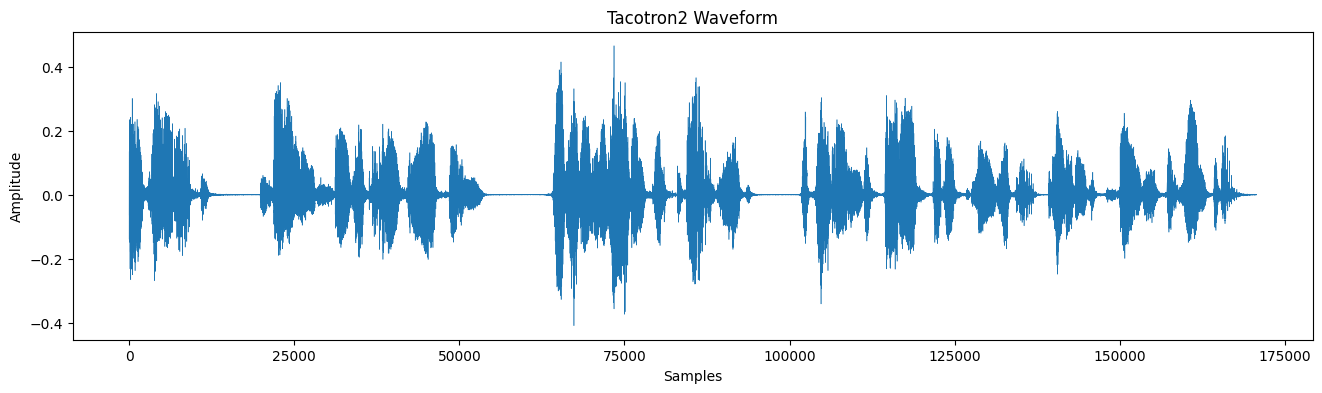

In [7]:
plot_audio_waveform(audio_np, "Tacotron2 Waveform")

In [8]:
save_and_play_audio(audio_np, 22050, "tacotron_output.wav")

'tacotron_output.wav'

## Algorithm 2: XTTS v2 (Coqui) (Voice Cloning)

In [ ]:
from TTS.api import TTS
from TTS.tts.configs.xtts_config import XttsConfig
torch.serialization.add_safe_globals([XttsConfig])

In [ ]:
xtts = TTS("tts_models/multilingual/multi-dataset/xtts_v2", gpu=(device=="cuda"))

In [ ]:
text = preprocess_text_for_tts("Hello there! This is an example of XTTS v2 using a consistent default speaker. It sounds quite natural, doesn't it?")
xtts.tts_to_file(text=text, speaker_wav="default_speaker.wav", language="en", file_path="xtts_output.wav")
xtts_audio, sr = sf.read("xtts_output.wav")
xtts_audio = postprocess_audio(xtts_audio, sr)
sf.write("xtts_output.wav", xtts_audio, sr)

In [ ]:
plot_audio_waveform(xtts_audio, "XTTS v2 Waveform")

In [ ]:
save_and_play_audio(xtts_audio, sr, "xtts_output.wav")

## Algorithm 3: VITS (Recommended, Speaker Selectable)

This one WORKS and sounds good! After running the code below once, you might need to restart the session from the runtime menu and run it again for imports to work properly.

In [4]:
# --- Step 1: Ensure GPU Runtime and Install Coqui TTS ---
# Make sure your Colab runtime is set to GPU (Runtime -> Change runtime type -> T4 GPU or similar)

print("Installing Coqui TTS...")
!pip install TTS soundfile==0.12.1 --quiet # soundfile version might need to be pinned for compatibility
print("Coqui TTS installed.")

Installing Coqui TTS...
Coqui TTS installed.


In [5]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.6.0+cu124
CUDA available: True
Using device: cuda


In [6]:
from TTS.api import TTS
from TTS.tts.configs.xtts_config import XttsConfig
torch.serialization.add_safe_globals([XttsConfig])

In [18]:
# VITS: Multi-speaker
vits = TTS("tts_models/en/vctk/vits", gpu=(device=="cuda"))
speaker_id = "p226"  # change to p225 for female

/usr/local/lib/python3.11/dist-packages/TTS/api.py:70: UserWarning: `gpu` will be deprecated. Please use `tts.to(device)` instead.
  warnings.warn("`gpu` will be deprecated. Please use `tts.to(device)` instead.")


 > tts_models/en/vctk/vits is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.


In [19]:
def tts_vits(text):
  text = preprocess_text_for_tts(text)
  vits.tts_to_file(text=text, speaker=speaker_id, file_path="vits_output.wav")
  vits_audio, sr = sf.read("vits_output.wav")
  vits_audio = postprocess_audio(vits_audio, sr)
  sf.write("vits_output.wav", vits_audio, sr)
  plot_audio_waveform(vits_audio, "VITS Waveform")
  save_and_play_audio(vits_audio, sr, "vits_output.wav")

In [20]:
phrase = """Start! Hello there! This is a very natural sounding voice generated by a VITS model. It's quite fast too."""

tts_vits(phrase)

 > Text splitted to sentences.
['.', 'Start!', 'Hello there!', 'This is a very natural sounding voice generated by a VITS model.', "It's quite fast too."]
 > Processing time: 0.4934549331665039
 > Real-time factor: 0.060175434012042145
